In [10]:
############ LOAD in custom packages ################
import sys
import os
import pandas as pd
import numpy as np
import importlib
from fastdtw import dtw
import seaborn as sns
import matplotlib.pyplot as plt

# Get the absolute path of the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Define data directory
brighten_dir = os.path.join(project_root, 'BRIGHTEN_data')

# Add project root to sys.path
sys.path.append(project_root)

# Import and reload custom scripts
from scripts import preprocessing as pre
from scripts import visualization as vis
from scripts import feature_selection as fs
from scripts import clustering as cl
from scripts import variables as var
importlib.reload(pre)
importlib.reload(vis)
importlib.reload(fs)
importlib.reload(cl)
importlib.reload(var)

################ DEFINE column variables from data ###################
from scripts.variables import id_columns, demographic_columns, daily_cols_v1, daily_v2_common 
from scripts.variables import phq2_cols, phq9_cols, weekly_cols, passive_cols, survey_cols
from scripts.variables import df_names, df_mis, df_names_with_mis





DATAFRAME: v1_day
In df there are 223 subjects.


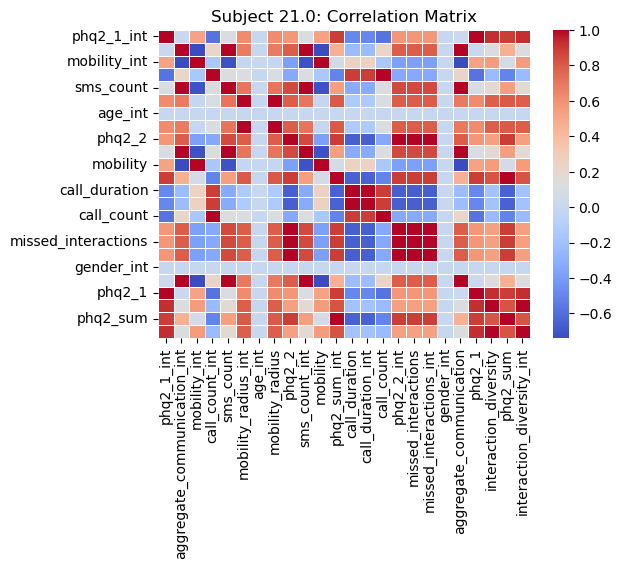

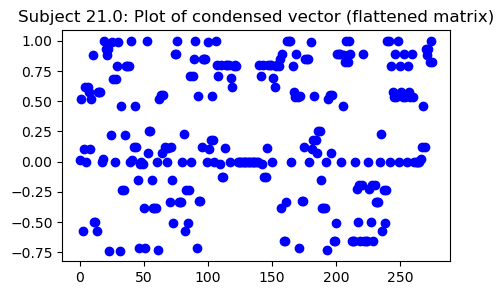

207 subs with symptom matrices
207 filled condensed arrays


DATAFRAME: v2_day
In df there are 6 subjects.


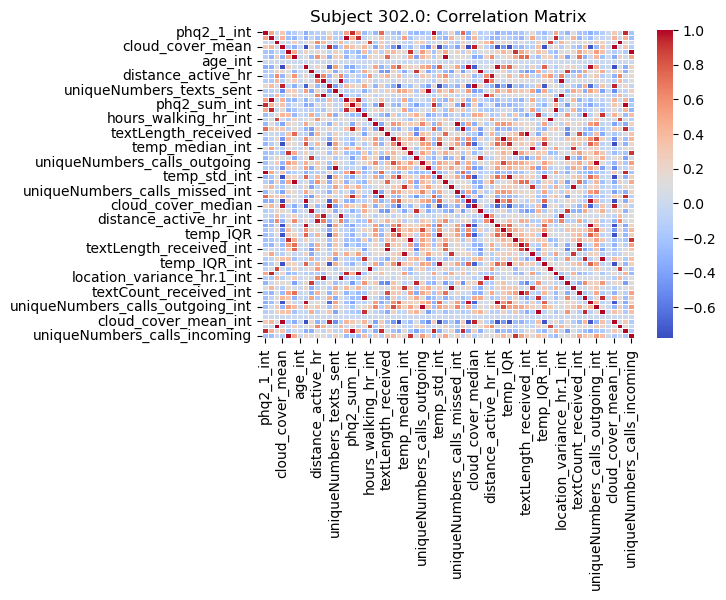

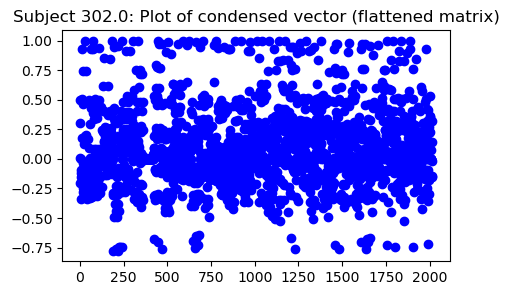

4 subs with symptom matrices
4 filled condensed arrays


DATAFRAME: v1_week
In df there are 188 subjects.


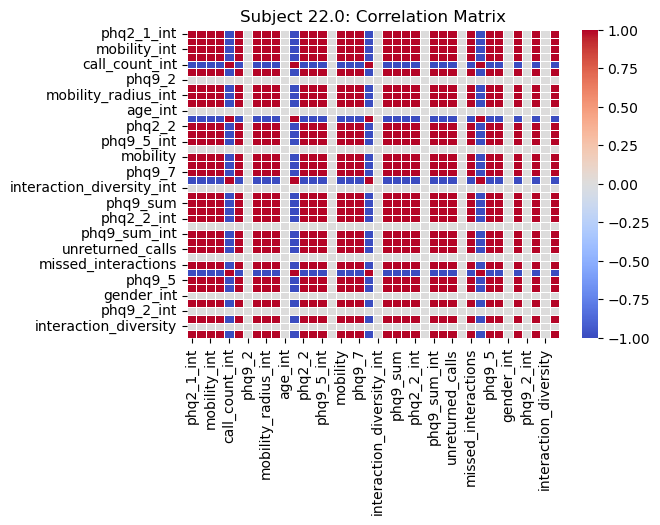

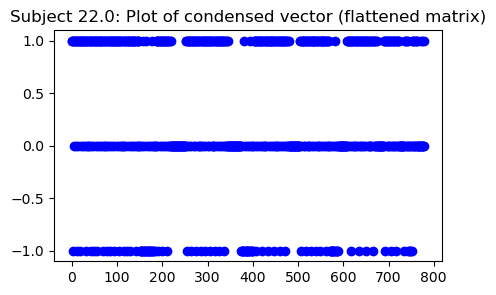

165 subs with symptom matrices
165 filled condensed arrays


DATAFRAME: v2_week
In df there are 3 subjects.


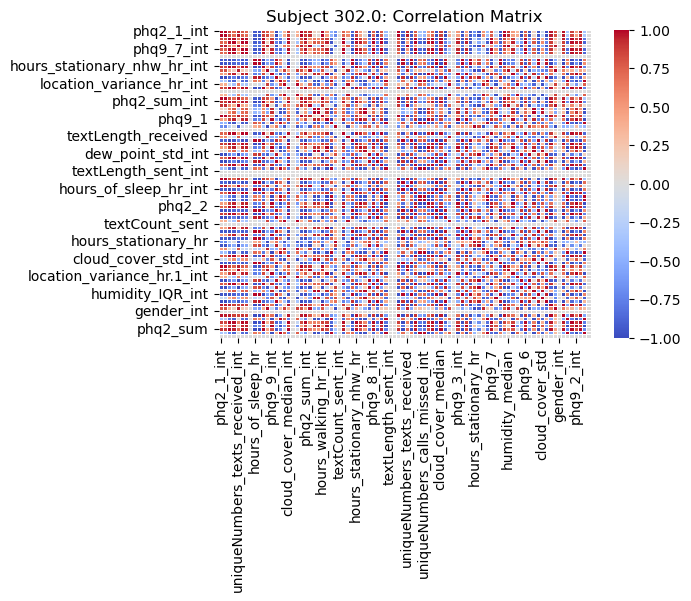

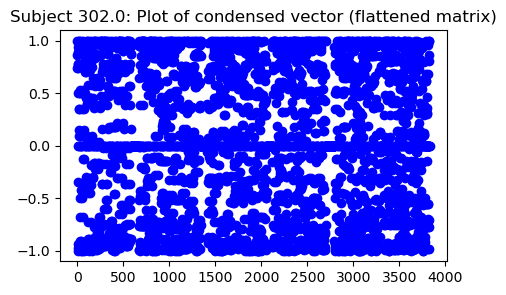

3 subs with symptom matrices
3 filled condensed arrays


In [18]:
#### Take the average of each subject's symptom correlation and use it to make clusters of variables
symptom_matrices_df_dict = {}
flattened_matrices_df_dict = {}
demographic_vars = ['gender','education','race','age']                # covariates


# Create dicts of all subjects' correlation matrices
for name in df_names:
    df_scaled = pd.read_csv(os.path.join(brighten_dir, f'{name}_clean.csv'))
    df_scaled = df_scaled.loc[:, ~df_scaled.columns.str.contains('^Unnamed')]  
    print(f'\n\nDATAFRAME: {name}')
    ignore_cols = demographic_vars + id_columns
    symptom_matrix_dict, flattened_matrix_dict = fs.make_symptom_matrices(df_scaled, ignore_cols, num_to_plot=1)
    symptom_matrices_df_dict[name] = symptom_matrix_dict
    flattened_matrices_df_dict[name] = flattened_matrix_dict



/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


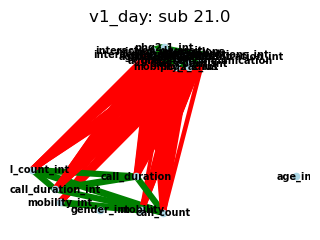

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


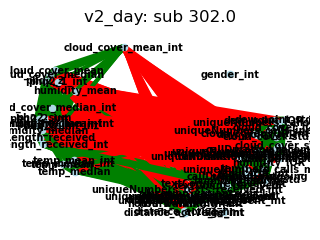

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


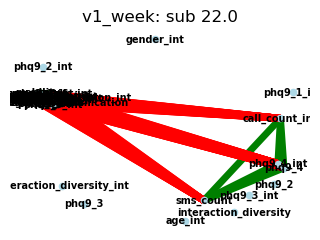

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


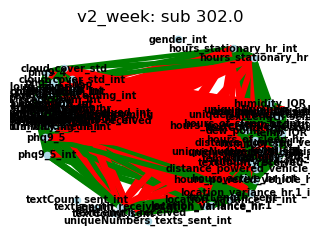

In [19]:
############### Plot individual networks of symptom matrices #################

for name, df_dict in symptom_matrices_df_dict.items():
    count=0
    for sub, corr_matrix in df_dict.items():
        if count<1:
            fs.plot_network(corr_matrix, title=f'{name}: sub {sub}')
            count=+1

In [13]:
# Double check where 'labels' are for columns
symptom_matrices_df_dict['v1_day'][list(symptom_matrices_df_dict['v1_day'].keys())[0]].index

Index(['phq2_1_int', 'aggregate_communication_int', 'mobility_int',
       'call_count_int', 'sms_count', 'mobility_radius_int', 'age_int',
       'mobility_radius', 'phq2_2', 'sms_count_int', 'mobility',
       'phq2_sum_int', 'call_duration', 'call_duration_int', 'call_count',
       'phq2_2_int', 'missed_interactions', 'missed_interactions_int',
       'gender_int', 'aggregate_communication', 'Unnamed: 0',
       'interaction_diversity', 'phq2_1', 'phq2_sum',
       'interaction_diversity_int'],
      dtype='object')

v1_day
(24, 24) variables included


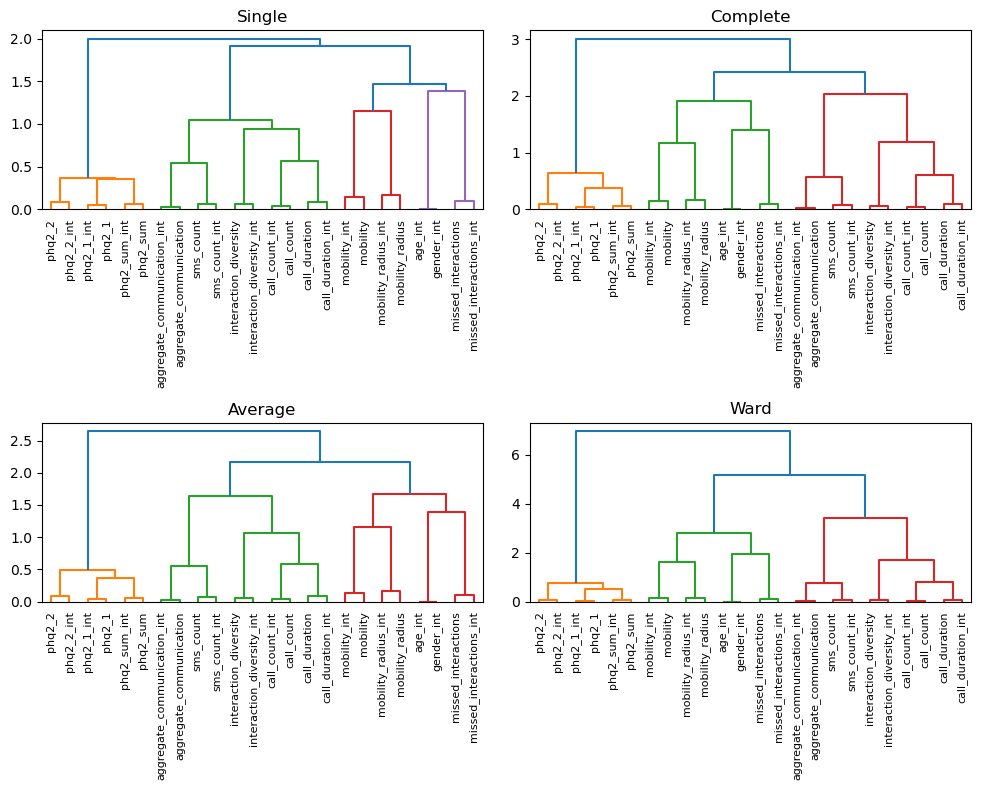

v2_day
(64, 64) variables included


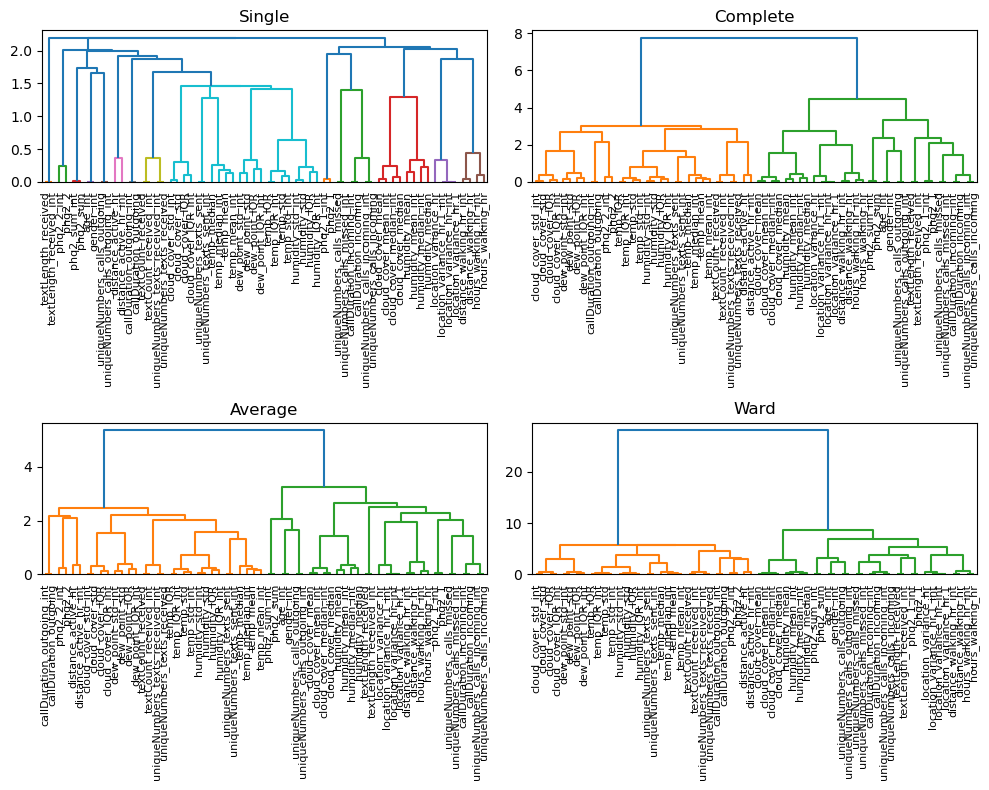

v1_week
(40, 40) variables included


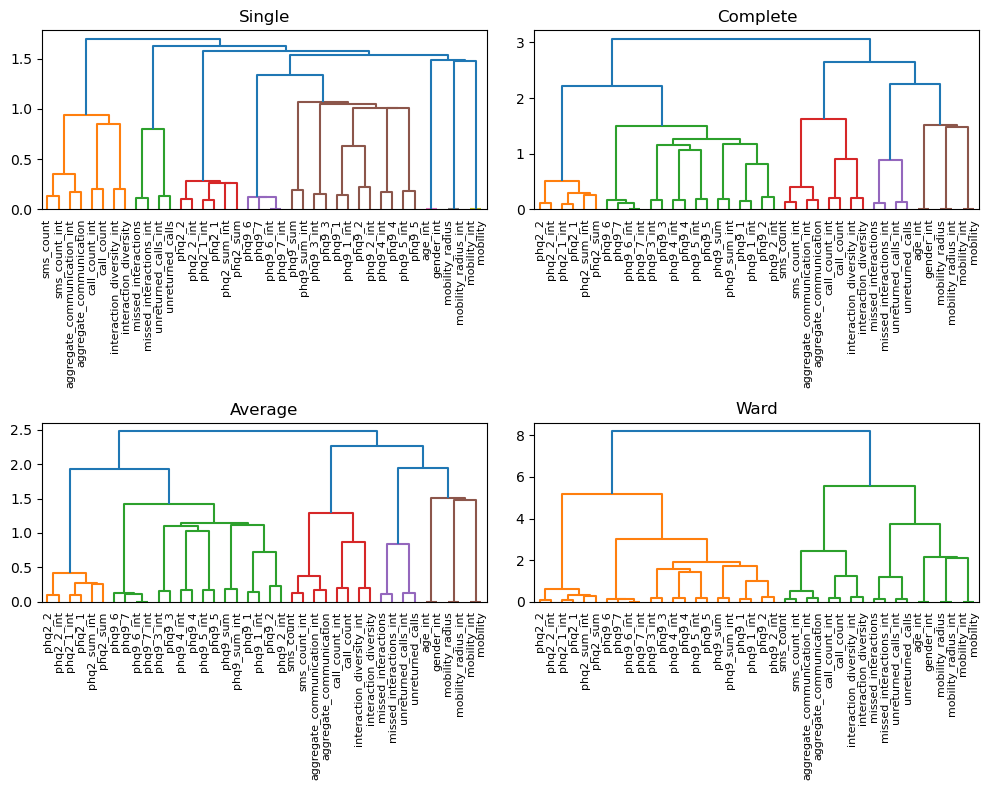

v2_week
(88, 88) variables included


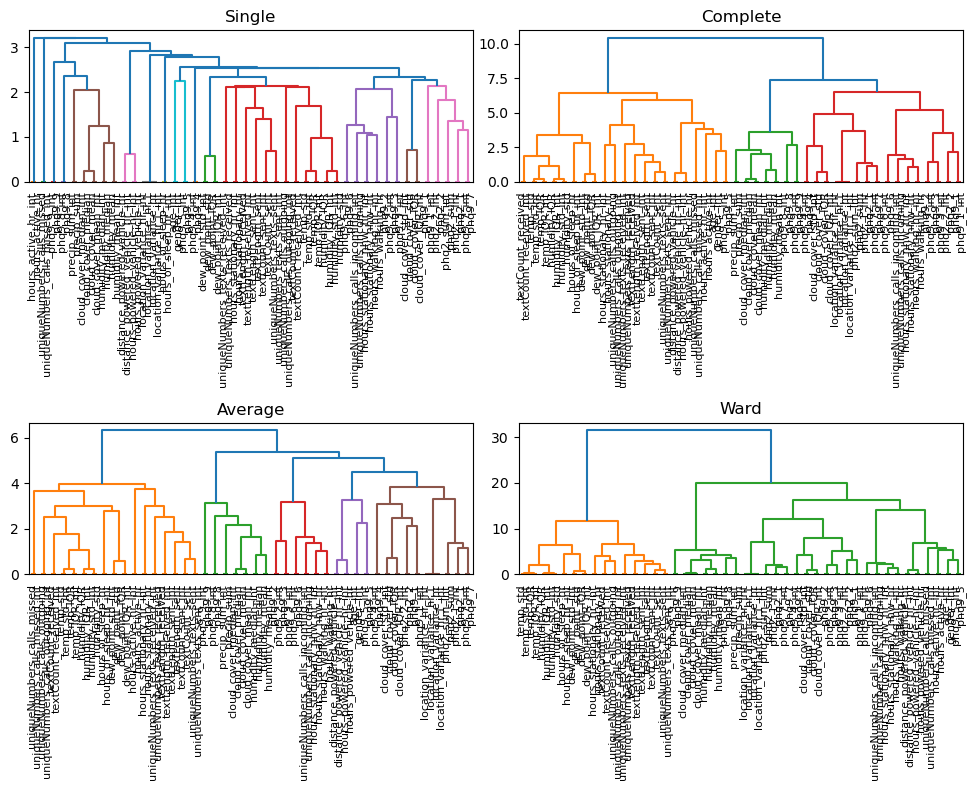

In [20]:
## Plot options
for name, df in symptom_matrices_df_dict.items():
    avg_matrix = fs.average_matrix(df)
    fs.plot_hier_agg(avg_matrix, df[list(df.keys())[0]].index, is_dict=False, group_title=f'{name}') # 3, ward


Mark down best fits:
v1_day -> 5, average
v1_week_phq9 -> 5, single
v2_day_fm -> 5, single
v2_week_phq9_fm -> 5 single


In [15]:
################# Create cluster_dict of Variables + Cluster Labels ############

clust_dict = {}
# clust_dict['v1_day'] = v1_day_clust_dict
for name, dictionary in symptom_matrices_df_dict.items():
    avg_matrix = fs.average_matrix(dictionary)
    if 'v1_day' in name:
        clust_dict[name] = fs.hier_agg_clustering(avg_matrix, dictionary[list(dictionary.keys())[0]].index, n_clusters=4, linkage='average', is_dict=False)

    if 'v2_day' in name or 'v1_week' in name or 'v2_week' in name:
       clust_dict[name] = fs.hier_agg_clustering(avg_matrix, dictionary[list(dictionary.keys())[0]].index, n_clusters=5, linkage='average', is_dict=False)


In [16]:
################# Create df_pca of Variables + 1st PC of clusters Labels ############

dfs_pca = {}
dfs_pca_dict = {}
for name in df_names:
    df_scaled = pd.read_csv(os.path.join(brighten_dir, f'{name}_scaled.csv'))
    name = name.replace('_residuals_scaled','')
    print(f'\nFor {name}')
    dfs_pca[name], dfs_pca_dict[name] = fs.pca_on_clusters(df_scaled, clust_dict[name], n_clusters=5)



For v1_day
Cols for cluster 0: ['aggregate_communication', 'call_count', 'call_duration', 'interaction_diversity', 'sms_count']
Cols for cluster 1: ['mobility', 'mobility_radius']
Cols for cluster 2: ['missed_interactions']
Cols for cluster 3: ['phq2_1', 'phq2_2', 'phq2_sum']
Skipping cluster 4: No variables assigned.

For v2_day
Cols for cluster 0: ['distance_walking_hr', 'hours_walking_hr', 'location_variance_hr', 'callDuration_incoming', 'textLength_received', 'uniqueNumbers_calls_incoming', 'uniqueNumbers_calls_missed', 'phq2_1', 'location_variance_hr.1']
Cols for cluster 1: ['distance_active_hr', 'callDuration_outgoing', 'textCount_received', 'uniqueNumbers_texts_received', 'uniqueNumbers_texts_sent', 'temp_mean', 'dew_point_IQR', 'humidity_IQR', 'temp_IQR', 'cloud_cover_IQR', 'cloud_cover_std', 'dew_point_std', 'humidity_std', 'temp_std', 'temp_median', 'phq2_2']
Cols for cluster 2: ['uniqueNumbers_calls_outgoing', 'phq2_sum']
Cols for cluster 3: ['cloud_cover_mean', 'humidity_m

In [ ]:
# # Name the clusters
dfs_pca_dict['v1_day'][0]['name']= 'pc_communication'
dfs_pca_dict['v1_day'][1]['name']= 'pc_mobility'
dfs_pca_dict['v1_day'][2]['name']= 'pc_missed_interactions'
dfs_pca_dict['v1_day'][3]['name']= 'pc_depression_phq2'

dfs_pca_dict['v2_day'][0]['name']= 'pc_activity'
dfs_pca_dict['v2_day'][1]['name']= 'pc_stationary_hours'
dfs_pca_dict['v2_day'][2]['name']= 'pc_sleep_hours'
dfs_pca_dict['v2_day'][3]['name']= 'pc_depression_phq2'

dfs_pca_dict['v1_week'][0]['name']= 'pc_communication'
dfs_pca_dict['v1_week'][1]['name']= 'pc_depression_phq9'
dfs_pca_dict['v1_week'][2]['name']= 'pc_mobility'
dfs_pca_dict['v1_week'][3]['name']= 'pc_missed_communications'
dfs_pca_dict['v1_week'][4]['name']= 'pc_depression_phq2'

dfs_pca_dict['v2_week'][0]['name']= 'pc_activity'
dfs_pca_dict['v2_week'][1]['name']= 'pc_depression_phq9'
dfs_pca_dict['v2_week'][2]['name']= 'pc_depression_phq2'
dfs_pca_dict['v2_week'][3]['name']= 'pc_stationary_hours'
dfs_pca_dict['v2_week'][4]['name']= 'pc_sleep_hours'



for name in df_names:
    df_scaled = pd.read_csv(os.path.join(brighten_dir, f'{name}_scaled.csv'))
    dfs_pca[name] = fs.merge_df_via_cluster_pca_dict(df_scaled, dfs_pca_dict[name], on_columns=['num_id', 'dt', 'week'])
    dfs_pca[name].to_csv(os.path.join(brighten_dir, f'{name}_pca.csv'), index=False)




KeyError: 4

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


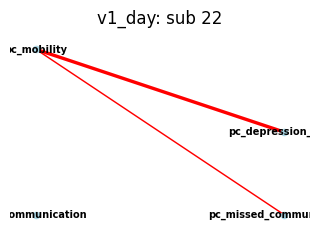

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


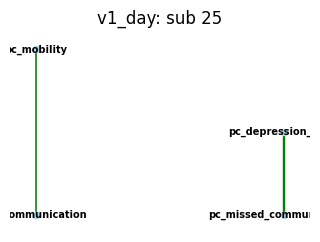

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


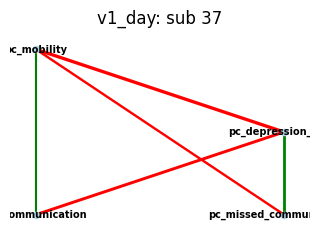

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


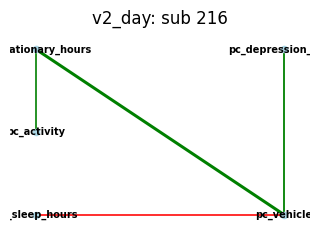

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


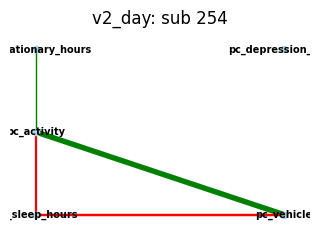

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


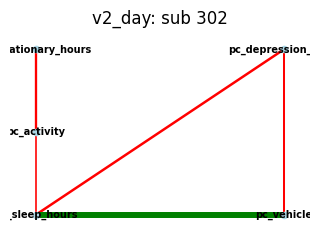

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


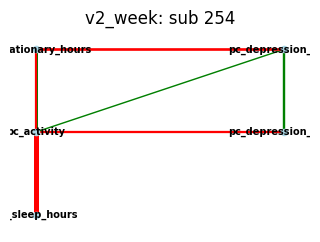

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


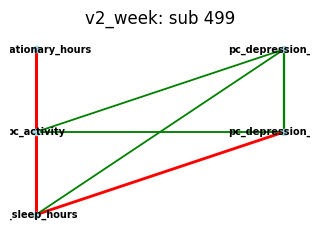

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


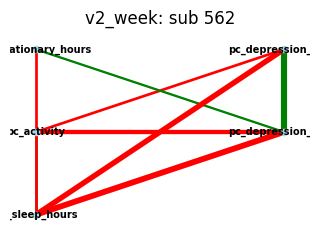

In [ ]:
############ Plot subjects' individual networks of PCs ############

# Predefine fixed positions for nodes
fixed_positions_v1 = {
    'pc_communication': (1, 1),
    'pc_missed_communications': (1, 2),
    'pc_missed_communications': (2, 1),
    'pc_mobility': (1, 3),
    'pc_depression_phq2': (2, 2),
    'pc_depression_phq9': (2, 3)
}

fixed_positions_v2 = {
    'pc_activity': (1, 2),
    'pc_sleep_hours': (1, 1),
    'pc_vehicle': (2, 1),
    'pc_stationary_hours': (1, 3),
    'pc_depression_phq9': (2, 2),
    'pc_depression_phq2': (2, 3)
}


for name, df in dfs_pca.items():
    count=0
    cols=[col for col in df.columns.to_list() if 'pc_' in col]
    for sub in df['num_id'].unique():
        sub_df = df[df['num_id']==sub]
        if sub_df.shape[0] > 8:
            if count<3:
                if 'v1' in name:
                    fs.plot_network(sub_df, cols, title=f'{name}: sub {sub}', threshold=0.2, fixed_positions=fixed_positions_v1)
                    count+=1
                elif 'v2' in name:
                    fs.plot_network(sub_df, cols, title=f'{name}: sub {sub}', threshold=0.2, fixed_positions=fixed_positions_v2)
                    count+=1


## Checking for collinearity




For v1_day:


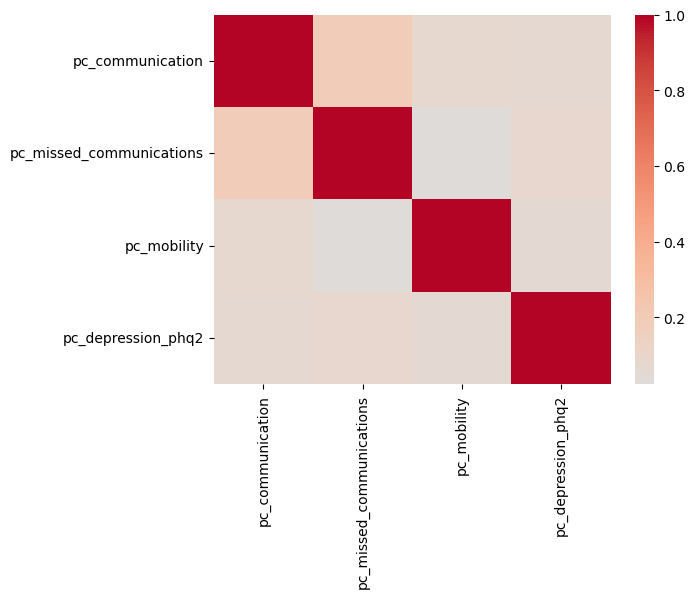



For v2_day:


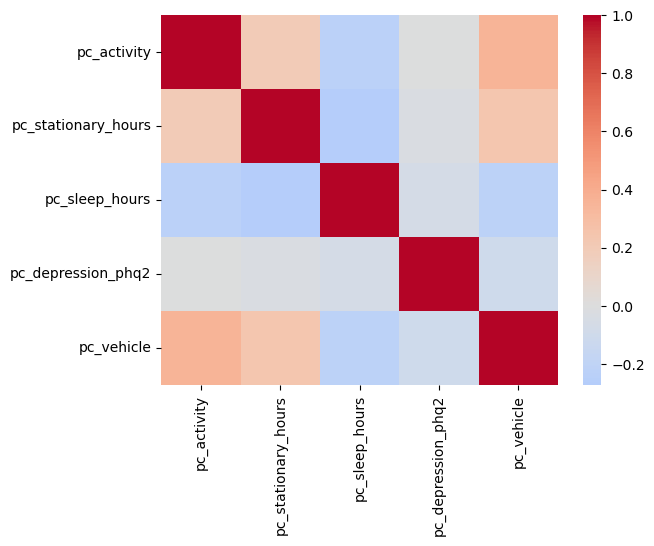



For v1_week:


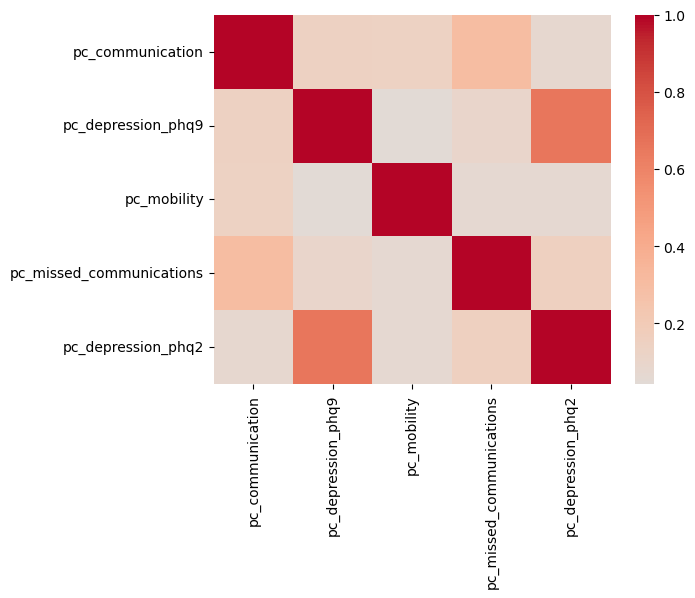



For v2_week:


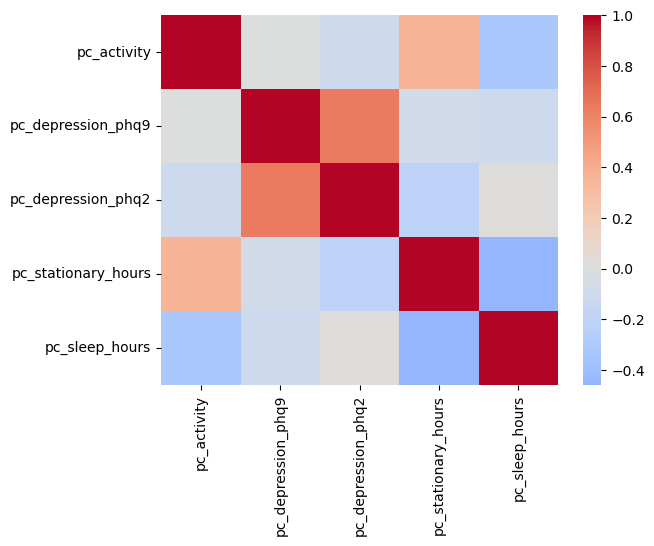

In [ ]:
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_pca.csv'))
    print(f'\n\nFor {name}:')
    numeric_cols = [col for col in df.columns.to_list() if 'pc_' in col]
    sns.heatmap(df[numeric_cols].corr(), cmap="coolwarm", center=0)
    plt.show()

We can see that our features are successfull not correlated, except phq2 and phq9, which is expected, and in most cases, phq2 won't be used to predict phq9. 

In [ ]:
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_pca.csv'))
    print(f'\n\nFor {name}:')
    numeric_cols = [col for col in df.columns.to_list() if col not in id_columns and col not in demographic_columns]
    print('\nInvestigating Kurtosis:')
    # Calculate kurtosis for numeric columns
    kurtosis_values = df[numeric_cols].select_dtypes(include='number').apply(lambda x: kurtosis(x, fisher=True))
    kurtosis_sorted = kurtosis_values.sort_values(ascending=False) # Sort by highest kurtosis
    print(kurtosis_sorted) #display
    
    for col in kurtosis_sorted.isna().index:
        print(f'Kurtosis is NaN for {col}:')
        print(df[col].nunique())      # Unique values
        print(df[col].isna().sum())   # Missing values
        print(df[col].describe())     # Summary stats




For v1_day:

Investigating Kurtosis:


NameError: name 'kurtosis' is not defined

In [ ]:
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_pca.csv'))
    print(f'\n\nFor {name}:')
    numeric_cols = [col for col in df.columns.to_list() if col not in id_columns and col not in demographic_columns]
    print('\nInvestigating skew:')
    print(df[numeric_cols].skew(numeric_only=True).sort_values(ascending=False)) # sort by highest, display    



For v1_day:

Investigating skew:
call_duration               2.078382
unreturned_calls            2.042122
pc_missed_communications    1.871742
missed_interactions         1.813537
call_count                  1.798832
sms_count                   1.671904
aggregate_communication     1.605040
sms_length                  1.560022
mobility_radius             1.525489
mobility                    1.335693
pc_mobility                 1.211683
pc_communication            1.210253
interaction_diversity       1.120952
phq2_2                      0.836587
phq2_1                      0.803020
phq2_sum                    0.764736
pc_depression_phq2          0.723012
dtype: float64


For v2_day:

Investigating skew:
hours_walking               1.860919
distance_walking            1.788644
distance_powered_vehicle    1.775538
pc_vehicle                  1.477351
hours_powered_vehicle       1.281528
hours_active                1.065460
pc_sleep_hours              1.018176
pc_activity                